In [1]:
import numpy as np
import pandas as pd 

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from keras import regularizers

In [2]:
#fixed random seed for reproducibility 
np.random.seed(0)

In [3]:
# load dataset (input variables = X, output variables = Y)
df = pd.read_csv("TrainingData.csv")

#count the number of occurances for each osID
OsID_counts = df['OsID'].value_counts()

#filter for osIDs that have 10 or more occurances
OsID_counts_filtered = OsID_counts[OsID_counts >= 10]

#assign a label for each osID 
OsID_labels = {}
class_no = 0
for osID in OsID_counts_filtered.index:
    OsID_labels[osID] = class_no
    class_no +=1

#filter the dataset with osID that contain 10 or more occurances
dataGene = df[df['OsID'].isin(OsID_counts_filtered.index)]

dataGene = dataGene.drop(['Class', 'Trait'],axis=1)

# Add a new column 'class' to the filtered dataset
dataGene['class'] = dataGene['OsID'].map(OsID_labels)

#print("Summary of dataGene:\n",dataGene.describe())

In [4]:
X = dataGene.drop(['class','OsID'], axis=1) # exclude class & OsID column
Y = dataGene['class']

#input feature names in order of descending importance scores in PCC feature selection method
feature_names = ['CoExpression', 'PCC', 'PPI', 'Root10DaysSeedling', 'Leaf21DaysSeedling',
                 'Leaf45DaysOldPlant', 'log_2FoldChange', 'ET', 'Shoot10DaysSeedling', 'Shoot3DaysSeedling', 
                 'Shoot35DaysSeedling', 'Shoot14DaysSeedling', 'Root17DaysSeedling', 'Shoot17DaysSeedling', 'Shoot21DaysSeedling',
                 'Root24DaysSeedling', 'Root14DaysSeedling', 'Root21DaysSeedling', 'Root52DaysSeedling', 'Root35DaysSeedling']

X_fs = X.reindex(columns=feature_names)

print("Shape of X:\n",X.shape)
print("Shape of Y:\n",Y.shape)

# Statistical summary of the variables
#print("Summary of X:\n",X.describe())
#print("Summary of Y:\n",Y.describe())

# Check for class imbalance
print(df.groupby(Y).size())

# change both input and target variables datatype to ndarray

X_fs = X_fs.values # 2-D array

# select target variable 

Y = Y.values #1-D array
Y = Y.reshape(-1, 1)


Shape of X:
 (41110, 20)
Shape of Y:
 (41110,)
class
0.0      1800
1.0      1296
2.0      1260
3.0      1218
4.0      1026
5.0      1008
6.0       930
7.0       912
8.0       880
9.0       798
10.0      792
11.0      759
12.0      729
13.0      720
14.0      702
15.0      693
16.0      672
17.0      640
18.0      625
19.0      570
20.0      546
21.0      506
22.0      483
23.0      448
24.0      432
25.0      384
26.0      360
27.0      360
28.0      320
29.0      312
         ... 
343.0      12
344.0      12
345.0      12
346.0      12
347.0      12
348.0      12
349.0      12
350.0      12
351.0      12
352.0      12
353.0      12
354.0      12
355.0      11
356.0      11
357.0      11
358.0      11
359.0      11
360.0      11
361.0      10
362.0      10
363.0      10
364.0      10
365.0      10
366.0      10
367.0      10
368.0      10
369.0      10
370.0      10
371.0      10
372.0      10
Length: 373, dtype: int64


Class=0, n=1800 (4.378%)
Class=1, n=1296 (3.153%)
Class=2, n=1260 (3.065%)
Class=3, n=1218 (2.963%)
Class=4, n=1026 (2.496%)
Class=5, n=1008 (2.452%)
Class=6, n=930 (2.262%)
Class=7, n=912 (2.218%)
Class=8, n=880 (2.141%)
Class=9, n=798 (1.941%)
Class=10, n=792 (1.927%)
Class=11, n=759 (1.846%)
Class=12, n=729 (1.773%)
Class=13, n=720 (1.751%)
Class=14, n=702 (1.708%)
Class=15, n=693 (1.686%)
Class=16, n=672 (1.635%)
Class=17, n=640 (1.557%)
Class=18, n=625 (1.520%)
Class=19, n=570 (1.387%)
Class=20, n=546 (1.328%)
Class=21, n=506 (1.231%)
Class=22, n=483 (1.175%)
Class=23, n=448 (1.090%)
Class=24, n=432 (1.051%)
Class=25, n=384 (0.934%)
Class=26, n=360 (0.876%)
Class=27, n=360 (0.876%)
Class=28, n=320 (0.778%)
Class=29, n=312 (0.759%)
Class=30, n=312 (0.759%)
Class=31, n=306 (0.744%)
Class=32, n=304 (0.739%)
Class=33, n=299 (0.727%)
Class=34, n=297 (0.722%)
Class=35, n=296 (0.720%)
Class=36, n=280 (0.681%)
Class=37, n=264 (0.642%)
Class=38, n=260 (0.632%)
Class=39, n=253 (0.615%)
Clas

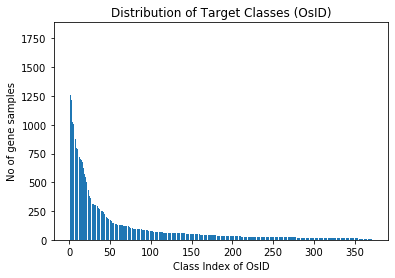

In [5]:
from collections import Counter
# summarize distribution
counter = Counter(Y.flatten())

# sort counter by keys
counter = dict(sorted(counter.items()))

for k,v in counter.items():
 per = v / len(Y.flatten()) * 100
 print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar( counter.keys(), counter.values())

plt.ylabel('No of gene samples')
plt.xlabel('Class Index of OsID')
plt.title('Distribution of Target Classes (OsID)')
plt.show()

In [6]:
def draw_confusion_matrix(cm):
    plt.figure(figsize=(12,8))
    sns.heatmap(cm,annot=True,fmt="d", center=0, cmap='autumn') 
    plt.title("Confusion Matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [7]:
# prepare target data
def prepare_targets(y_train, y_test):
	le = LabelEncoder()
	
	#fit the encoders only to the training data and then transform both train and test data
	y_train_enc = le.fit_transform(y_train)
	y_test_enc = le.transform(y_test)

	return y_train_enc, y_test_enc

In [8]:
# define baseline model (MLP)
def MLP_model(input_dim):

    model = Sequential()
    model.add(Dense(60, input_dim=input_dim,bias_initializer='normal', activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(20,bias_initializer='normal',activation='relu',kernel_regularizer=regularizers.l2(0.0001)))
    model.add(Dense(373,kernel_initializer='normal', activation='softmax')) #softmax for multi-class classification, num_classes = 373

    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [9]:
# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_fs, Y, test_size=0.33, random_state=1)

# prepare output data
y_train_enc, y_test_enc = prepare_targets(y_train, y_test)

# Define the number of folds for k-fold cross-validation
k = 5

# Define the cross-validation method
cv_method = StratifiedKFold(n_splits=k)

# Initialize the list to store the history, train & validation(accuracy & loss) for each model
models = []
model_history = []
model_accuracy = []
model_train_acc = []
model_train_loss = []
model_val_acc = []
model_val_loss = []


for i in range(1,21):

    models_fold = []
    hist = []
    train_accuracy = []
    train_loss = []
    val_accuracy = []
    val_loss = []
    test_accuracy = []

    print("Number of input features:",i)

    # Select the input features from the input data
    X_train_selected = X_train[:, :i]
    X_test_selected = X_test[:, :i]

    # Loop over the folds
    for fold, (train_index, val_index) in enumerate(cv_method.split(X_train_selected, y_train)):

        print("Fold:", fold+1)

        # Split the data into train and validation sets using the current fold index
        X_train_fold  = X_train_selected[train_index]
        y_train_fold  = y_train[train_index]
        X_val_fold = X_train_selected[val_index]
        y_val_fold = y_train[val_index]

        # Prepare the target data
        y_train_fold_enc, y_val_fold_enc = prepare_targets(y_train_fold, y_val_fold)

        # build the model
        model = MLP_model(i)

        # Fit the model to the training data for the current fold
        history = model.fit(X_train_fold, to_categorical(y_train_fold_enc, num_classes=373), epochs=140, batch_size=5, verbose=1, validation_split = 0.33)
    
        # Evaluate the model on the validation data for the current fold
        val_scores = model.evaluate(X_val_fold, to_categorical(y_val_fold_enc, num_classes=373), verbose=0)
        val_accuracy.append(val_scores[1])
        val_loss.append(val_scores[0])

        # Evaluate the model on the test data for the current fold
        test_scores = model.evaluate(X_test_selected, to_categorical(y_test_enc, num_classes=373), verbose=0)
        test_accuracy.append(test_scores[1])

        # add the model to the list of models
        models_fold.append(model)
        hist.append(history)

        # store the training accuracy and loss for each fold
        train_accuracy.append(history.history['accuracy'])
        train_loss.append(history.history['loss'])
        
    # Calculate the average test and validation accuracy and loss across all folds
    avg_test_acc = sum(test_accuracy) / len(test_accuracy)
    avg_val_acc = sum(val_accuracy) / len(val_accuracy)
    avg_val_loss = sum(val_loss) / len(val_loss)

    # Print the average validation and test accuracy and loss
    print("Average Validation Accuracy:", avg_val_acc)
    print("Average Validation Loss:",avg_val_loss)
    print("Average Test Accuracy:", avg_test_acc)

    best_fold_index = test_accuracy.index(max(test_accuracy))
    model_accuracy.append(test_accuracy[best_fold_index])
    models.append(models_fold[best_fold_index])
    model_history.append(hist[best_fold_index])
    model_train_acc.append(train_accuracy[best_fold_index])
    model_train_loss.append(train_loss[best_fold_index])
    model_val_acc.append(val_accuracy[best_fold_index])
    model_val_loss.append(val_loss[best_fold_index])


    print("Final Test Accuracy for each fold:", test_accuracy[best_fold_index])

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,


Number of input features: 1


C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Fold: 1
Epoch 1/140
2953/2953 [==============================] - 9s 2ms/step - loss: 5.0380 - accuracy: 0.0427 - val_loss: 4.9891 - val_accuracy: 0.0429
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 4.9638 - accuracy: 0.0456 - val_loss: 4.9700 - val_accuracy: 0.0446
Epoch 3/140
2953/2953 [==============================] - 7s 2ms/step - loss: 4.9503 - accuracy: 0.0445 - val_loss: 4.9579 - val_accuracy: 0.0446
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9422 - accuracy: 0.0457 - val_loss: 4.9542 - val_accuracy: 0.0446
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9383 - accuracy: 0.0457 - val_loss: 4.9502 - val_accuracy: 0.0446
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9355 - accuracy: 0.0453 - val_loss: 4.9564 - val_accuracy: 0.0446
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.9340 - accuracy: 0.0456 - val_loss: 4.9475 

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 4.9914 - accuracy: 0.0497 - val_loss: 4.9014 - val_accuracy: 0.0543
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.8513 - accuracy: 0.0556 - val_loss: 4.8706 - val_accuracy: 0.0569
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.8195 - accuracy: 0.0570 - val_loss: 4.8561 - val_accuracy: 0.0582
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.7970 - accuracy: 0.0579 - val_loss: 4.8395 - val_accuracy: 0.0569
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.7783 - accuracy: 0.0589 - val_loss: 4.8324 - val_accuracy: 0.0582
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.7615 - accuracy: 0.0591 - val_loss: 4.8303 - val_accuracy: 0.0601
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 4.7494 - accuracy: 0.0600 - val_loss: 4.8319 - val_accuracy: 0.05

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 4.8017 - accuracy: 0.0759 - val_loss: 4.6472 - val_accuracy: 0.0785
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.5714 - accuracy: 0.0840 - val_loss: 4.6041 - val_accuracy: 0.0800
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.5299 - accuracy: 0.0842 - val_loss: 4.5810 - val_accuracy: 0.0821
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.5044 - accuracy: 0.0837 - val_loss: 4.5613 - val_accuracy: 0.0826
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.4853 - accuracy: 0.0873 - val_loss: 4.5625 - val_accuracy: 0.0811
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.4708 - accuracy: 0.0870 - val_loss: 4.5578 - val_accuracy: 0.0828
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 4.4580 - accuracy: 0.0861 - val_loss: 4.5568 - val_accuracy: 0.09

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 4.3344 - accuracy: 0.1306 - val_loss: 3.7346 - val_accuracy: 0.1848
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 3.3468 - accuracy: 0.2364 - val_loss: 3.1559 - val_accuracy: 0.2426
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.8622 - accuracy: 0.3092 - val_loss: 2.8288 - val_accuracy: 0.2981
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.5677 - accuracy: 0.3567 - val_loss: 2.5282 - val_accuracy: 0.3819
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.3864 - accuracy: 0.3752 - val_loss: 2.4391 - val_accuracy: 0.3571
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.2695 - accuracy: 0.3976 - val_loss: 2.3395 - val_accuracy: 0.3974
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.1986 - accuracy: 0.4065 - val_loss: 2.2517 - val_accuracy: 0.43

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 4.1902 - accuracy: 0.1606 - val_loss: 3.4235 - val_accuracy: 0.2563
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 2.8563 - accuracy: 0.3480 - val_loss: 2.6161 - val_accuracy: 0.3596
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 2.2446 - accuracy: 0.4421 - val_loss: 2.2293 - val_accuracy: 0.4733
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.8718 - accuracy: 0.5088 - val_loss: 1.8521 - val_accuracy: 0.5650
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.6447 - accuracy: 0.5568 - val_loss: 1.6839 - val_accuracy: 0.5909
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.4862 - accuracy: 0.5927 - val_loss: 1.6008 - val_accuracy: 0.5740
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.3714 - accuracy: 0.6145 - val_loss: 1.6176 - val_accuracy: 0.54

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 7s 2ms/step - loss: 3.5250 - accuracy: 0.3022 - val_loss: 2.3932 - val_accuracy: 0.4895
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.7563 - accuracy: 0.5980 - val_loss: 1.4660 - val_accuracy: 0.6961
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.1377 - accuracy: 0.7117 - val_loss: 1.1863 - val_accuracy: 0.7255
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.8817 - accuracy: 0.7534 - val_loss: 0.9539 - val_accuracy: 0.7826
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.7437 - accuracy: 0.7813 - val_loss: 0.9260 - val_accuracy: 0.7371
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.6712 - accuracy: 0.8017 - val_loss: 0.7868 - val_accuracy: 0.7892
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.6069 - accuracy: 0.8176 - val_loss: 0.7724 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 3.6730 - accuracy: 0.2846 - val_loss: 2.6373 - val_accuracy: 0.4530
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.9800 - accuracy: 0.5677 - val_loss: 1.7318 - val_accuracy: 0.6529
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.2535 - accuracy: 0.6975 - val_loss: 1.2610 - val_accuracy: 0.7434
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.9147 - accuracy: 0.7595 - val_loss: 1.0006 - val_accuracy: 0.7697
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.7422 - accuracy: 0.7897 - val_loss: 0.8609 - val_accuracy: 0.7973
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6390 - accuracy: 0.8155 - val_loss: 0.7573 - val_accuracy: 0.8122
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.5764 - accuracy: 0.8299 - val_loss: 0.6956 - val_accuracy: 0.82

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 3.3281 - accuracy: 0.3243 - val_loss: 2.2237 - val_accuracy: 0.5281
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.6836 - accuracy: 0.6087 - val_loss: 1.4416 - val_accuracy: 0.6850
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.1415 - accuracy: 0.7054 - val_loss: 1.1094 - val_accuracy: 0.7426
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8939 - accuracy: 0.7507 - val_loss: 0.9709 - val_accuracy: 0.7699
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.7507 - accuracy: 0.7844 - val_loss: 0.8427 - val_accuracy: 0.7765
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.6631 - accuracy: 0.8017 - val_loss: 0.7591 - val_accuracy: 0.8159
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.6012 - accuracy: 0.8245 - val_loss: 0.6568 - val_accuracy: 0.82

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 7s 2ms/step - loss: 3.1191 - accuracy: 0.3839 - val_loss: 1.8601 - val_accuracy: 0.6260
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.2355 - accuracy: 0.7317 - val_loss: 1.0380 - val_accuracy: 0.7654
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.7340 - accuracy: 0.8175 - val_loss: 0.7625 - val_accuracy: 0.8299
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.5325 - accuracy: 0.8558 - val_loss: 0.5836 - val_accuracy: 0.8574
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4320 - accuracy: 0.8816 - val_loss: 0.4735 - val_accuracy: 0.8838
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3742 - accuracy: 0.8940 - val_loss: 0.4486 - val_accuracy: 0.8859
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3362 - accuracy: 0.9047 - val_loss: 0.4929 - val_accuracy: 0.86

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 8s 2ms/step - loss: 2.8905 - accuracy: 0.4428 - val_loss: 1.5302 - val_accuracy: 0.7338
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.9971 - accuracy: 0.7891 - val_loss: 0.8128 - val_accuracy: 0.8456
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.5677 - accuracy: 0.8632 - val_loss: 0.6262 - val_accuracy: 0.8641
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4173 - accuracy: 0.8928 - val_loss: 0.5103 - val_accuracy: 0.8761
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3370 - accuracy: 0.9111 - val_loss: 0.4174 - val_accuracy: 0.9160
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2858 - accuracy: 0.9219 - val_loss: 0.3163 - val_accuracy: 0.9293
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2567 - accuracy: 0.9288 - val_loss: 0.3154 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 8s 2ms/step - loss: 3.0329 - accuracy: 0.4320 - val_loss: 1.6152 - val_accuracy: 0.7197
Epoch 2/140
2953/2953 [==============================] - 6s 2ms/step - loss: 1.0175 - accuracy: 0.8062 - val_loss: 0.8542 - val_accuracy: 0.8575
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.5477 - accuracy: 0.8815 - val_loss: 0.5744 - val_accuracy: 0.8899
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3810 - accuracy: 0.9101 - val_loss: 0.4280 - val_accuracy: 0.9172
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3018 - accuracy: 0.9242 - val_loss: 0.3731 - val_accuracy: 0.9185
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2544 - accuracy: 0.9361 - val_loss: 0.2843 - val_accuracy: 0.9438
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2251 - accuracy: 0.9422 - val_loss: 0.2550 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 8s 2ms/step - loss: 2.7337 - accuracy: 0.4869 - val_loss: 1.4112 - val_accuracy: 0.7488
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.8922 - accuracy: 0.8193 - val_loss: 0.7726 - val_accuracy: 0.8527
Epoch 3/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.4979 - accuracy: 0.8809 - val_loss: 0.5132 - val_accuracy: 0.8886
Epoch 4/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.3533 - accuracy: 0.9071 - val_loss: 0.3963 - val_accuracy: 0.9268
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2854 - accuracy: 0.9251 - val_loss: 0.3456 - val_accuracy: 0.9215
Epoch 6/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2414 - accuracy: 0.9377 - val_loss: 0.2863 - val_accuracy: 0.9275
Epoch 7/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2125 - accuracy: 0.9457 - val_loss: 0.2281 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/140
2953/2953 [==============================] - 8s 2ms/step - loss: 2.8587 - accuracy: 0.4592 - val_loss: 1.5589 - val_accuracy: 0.7291
Epoch 2/140
2953/2953 [==============================] - 7s 2ms/step - loss: 1.0339 - accuracy: 0.8010 - val_loss: 0.8354 - val_accuracy: 0.8453
Epoch 3/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.5791 - accuracy: 0.8809 - val_loss: 0.5559 - val_accuracy: 0.8944
Epoch 4/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.3789 - accuracy: 0.9142 - val_loss: 0.4265 - val_accuracy: 0.9202
Epoch 5/140
2953/2953 [==============================] - 6s 2ms/step - loss: 0.2788 - accuracy: 0.9327 - val_loss: 0.3222 - val_accuracy: 0.9425
Epoch 6/140
2953/2953 [==============================] - 7s 2ms/step - loss: 0.2262 - accuracy: 0.9461 - val_loss: 0.2896 - val_accuracy: 0.9378
Epoch 7/140
2953/2953 [==============================] - 8s 3ms/step - loss: 0.1939 - accuracy: 0.9531 - val_loss: 0.2379 - val_ac

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.9762 - accuracy: 0.4556 - val_loss: 1.6814 - val_accuracy: 0.7156
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 1.0624 - accuracy: 0.7966 - val_loss: 0.8323 - val_accuracy: 0.8546
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.5339 - accuracy: 0.8874 - val_loss: 0.5211 - val_accuracy: 0.9116
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3344 - accuracy: 0.9211 - val_loss: 0.4021 - val_accuracy: 0.9328
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2551 - accuracy: 0.9388 - val_loss: 0.3280 - val_accuracy: 0.9317
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2143 - accuracy: 0.9502 - val_loss: 0.2942 - val_accuracy: 0.9315
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1902 - accuracy: 0.9531 - val_loss: 0.2588 - val_accuracy: 0.94

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.8060 - accuracy: 0.4877 - val_loss: 1.4150 - val_accuracy: 0.7422
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8668 - accuracy: 0.8229 - val_loss: 0.7169 - val_accuracy: 0.8585
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4573 - accuracy: 0.8888 - val_loss: 0.4948 - val_accuracy: 0.8877
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3221 - accuracy: 0.9167 - val_loss: 0.3553 - val_accuracy: 0.9186
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2603 - accuracy: 0.9316 - val_loss: 0.2835 - val_accuracy: 0.9319
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2284 - accuracy: 0.9403 - val_loss: 0.2473 - val_accuracy: 0.9263
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1999 - accuracy: 0.9485 - val_loss: 0.2190 - val_accuracy: 0.94

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.8260 - accuracy: 0.4682 - val_loss: 1.4329 - val_accuracy: 0.7496
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8784 - accuracy: 0.8377 - val_loss: 0.7026 - val_accuracy: 0.8802
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4607 - accuracy: 0.9025 - val_loss: 0.4903 - val_accuracy: 0.8959
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3180 - accuracy: 0.9256 - val_loss: 0.3721 - val_accuracy: 0.9237
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2536 - accuracy: 0.9356 - val_loss: 0.3002 - val_accuracy: 0.9387
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2164 - accuracy: 0.9451 - val_loss: 0.3576 - val_accuracy: 0.9014
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1903 - accuracy: 0.9526 - val_loss: 0.2163 - val_accuracy: 0.95

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.8075 - accuracy: 0.4778 - val_loss: 1.3971 - val_accuracy: 0.7664
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8568 - accuracy: 0.8319 - val_loss: 0.8072 - val_accuracy: 0.8243
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4529 - accuracy: 0.8967 - val_loss: 0.4558 - val_accuracy: 0.9037
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3085 - accuracy: 0.9247 - val_loss: 0.3774 - val_accuracy: 0.9219
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2476 - accuracy: 0.9358 - val_loss: 0.2737 - val_accuracy: 0.9391
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2108 - accuracy: 0.9461 - val_loss: 0.2328 - val_accuracy: 0.9354
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1882 - accuracy: 0.9505 - val_loss: 0.2204 - val_accuracy: 0.93

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.8195 - accuracy: 0.4712 - val_loss: 1.4974 - val_accuracy: 0.7361
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.9533 - accuracy: 0.8127 - val_loss: 0.7812 - val_accuracy: 0.8574
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.5234 - accuracy: 0.8831 - val_loss: 0.5198 - val_accuracy: 0.8956
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.3603 - accuracy: 0.9142 - val_loss: 0.3942 - val_accuracy: 0.9086
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2766 - accuracy: 0.9309 - val_loss: 0.3327 - val_accuracy: 0.9310
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2361 - accuracy: 0.9388 - val_loss: 0.2889 - val_accuracy: 0.9329
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2087 - accuracy: 0.9461 - val_loss: 0.2516 - val_accuracy: 0.94

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.7459 - accuracy: 0.4860 - val_loss: 1.3856 - val_accuracy: 0.7589
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8626 - accuracy: 0.8344 - val_loss: 0.7102 - val_accuracy: 0.8823
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4419 - accuracy: 0.9081 - val_loss: 0.4804 - val_accuracy: 0.9064
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2928 - accuracy: 0.9339 - val_loss: 0.3088 - val_accuracy: 0.9392
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2279 - accuracy: 0.9449 - val_loss: 0.2462 - val_accuracy: 0.9542
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1938 - accuracy: 0.9540 - val_loss: 0.2140 - val_accuracy: 0.9541
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1733 - accuracy: 0.9575 - val_loss: 0.1967 - val_accuracy: 0.95

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:680: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  UserWarning,
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


2953/2953 [==============================] - 6s 2ms/step - loss: 2.6992 - accuracy: 0.5014 - val_loss: 1.3626 - val_accuracy: 0.7676
Epoch 2/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.8552 - accuracy: 0.8409 - val_loss: 0.7235 - val_accuracy: 0.8813
Epoch 3/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.4402 - accuracy: 0.9096 - val_loss: 0.5042 - val_accuracy: 0.9098
Epoch 4/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2867 - accuracy: 0.9350 - val_loss: 0.4360 - val_accuracy: 0.8960
Epoch 5/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.2162 - accuracy: 0.9498 - val_loss: 0.3367 - val_accuracy: 0.9319
Epoch 6/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1845 - accuracy: 0.9531 - val_loss: 0.2407 - val_accuracy: 0.9480
Epoch 7/140
2953/2953 [==============================] - 5s 2ms/step - loss: 0.1612 - accuracy: 0.9610 - val_loss: 0.1991 - val_accuracy: 0.95

In [10]:
#to show the no of input features and its corresponding model accuracy
model_list = []

#Iterate through each model's accuracy 
for i in range (len(model_accuracy)):
    #get the number of input features for the current model
    no_features = i + 1

    #round the model accuries to 3 d.p.
    rounded_model_acc = round(model_accuracy[i], 3)
    
    model_list.append([no_features, rounded_model_acc])

models_df = pd.DataFrame(model_list, columns=["No of input features", "Model accuracy"])

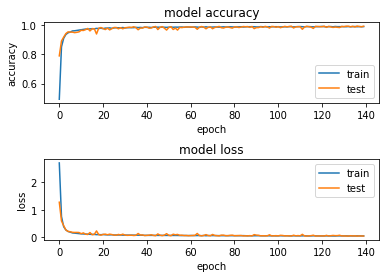

Final Test Accuracy: 0.9939559102058411


In [11]:
# Select the final model based on the max test accuracy across all models

best_model_index = model_accuracy.index(max(model_accuracy))

best_model = models[best_model_index]
best_model_history = model_history[best_model_index]
best_model_train_acc = model_train_acc[best_model_index]
best_model_train_loss = model_train_loss[best_model_index]
best_model_val_acc = model_val_acc[best_model_index]
best_model_val_loss = model_val_loss[best_model_index]

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(best_model_history.history['accuracy'])  
plt.plot(best_model_history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  

# summarize history for loss
plt.subplot(212)  
plt.plot(best_model_history.history['loss'])  
plt.plot(best_model_history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper right')  
plt.subplots_adjust(hspace=0.7)

plt.show() 

print("Final Test Accuracy:", model_accuracy[best_model_index])

In [12]:
#Select only the optimal number of input features for X_test
X_test = X_test[:,:(best_model_index+1)]

# Evaluate the best model on the test data
y_pred = best_model.predict(X_test)

# np.argmax() is used to convert the one-hot encoded predictions and test labels to class labels.
y_pred_label = np.argmax(y_pred, axis = 1)

# Print the classification report
print("Classification report:\n", classification_report(y_test_enc, y_pred_label))


424/424 [==============================] - 1s 2ms/step
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       591
           1       1.00      1.00      1.00       430
           2       1.00      1.00      1.00       419
           3       1.00      1.00      1.00       384
           4       1.00      1.00      1.00       339
           5       1.00      1.00      1.00       342
           6       1.00      1.00      1.00       310
           7       1.00      1.00      1.00       325
           8       1.00      1.00      1.00       294
           9       1.00      1.00      1.00       269
          10       1.00      1.00      1.00       296
          11       1.00      1.00      1.00       258
          12       1.00      1.00      1.00       247
          13       1.00      1.00      1.00       237
          14       1.00      1.00      1.00       239
          15       1.00      1.00      1.00       235
  

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

C:\Users\yoongsim\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


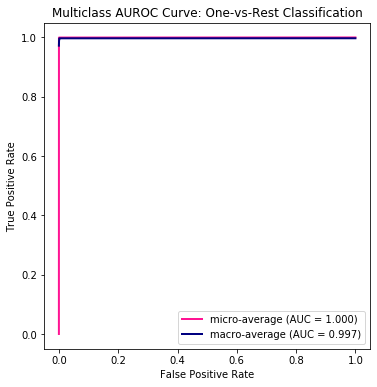

In [17]:
n_classes = 373
ohe_y_test_enc = to_categorical(y_test_enc, num_classes=373)

# Store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()

# Compute ROC curve and ROC area for each class (one-vs-rest)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(ohe_y_test_enc[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(ohe_y_test_enc.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
valid_classes = 0 
for i in range(n_classes):
    if np.sum(ohe_y_test_enc[:, i]) > 0:  # Exclude classes with no positive samples
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        valid_classes += 1

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

#Plot all OvR ROC curves together
fig, ax = plt.subplots(figsize=(8, 6))



plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average (AUC = {roc_auc['micro']:.3f})",
    color="deeppink",
    linewidth=2,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average (AUC = {roc_auc['macro']:.3f})",
    color="navy",
    linewidth=2,
)


plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass AUROC Curve: One-vs-Rest Classification")
plt.legend(loc="lower right")
plt.show()

In [18]:
import pickle

filepath = 'MLP_auroc.pkl'
data = {'MLP_fpr_macro': fpr['macro'],
        'MLP_tpr_macro': tpr['macro'],
        'MLP_auc_macro': roc_auc['macro']}

with open(filepath,'wb') as f:
    pickle.dump(data,f)

In [19]:
# extract class labels from test data
class_test = y_test_enc

# Invert OsID_labels dictionary
inv_OsID_labels = {v: k for k, v in OsID_labels.items()}

# map OsID values to the class labels
OsID_test = [inv_OsID_labels.get(value, 'Unknown') for value in class_test]

# create dataframe with OsID, true class, predicted class, and true/false columns
results = pd.DataFrame({
    'OsID': OsID_test,
    'True Class': y_test_enc,
    'Predicted Class': y_pred_label,
    'True/False': class_test == y_pred_label
})

# display dataframe
print(results.head())

# save results_df to a CSV file
results.to_csv('MLP_gene classification.csv', index=False)

           OsID  True Class  Predicted Class  True/False
0  Os11g0704500         328              328        True
1  Os09g0279600         161              161        True
2  Os03g0669100          17               17        True
3  Os05g0542500          34               34        True
4  Os09g0522000           7                7        True


In [16]:
print(models_df)

    No of input features  Model accuracy
0                      1           0.045
1                      2           0.089
2                      3           0.117
3                      4           0.591
4                      5           0.804
5                      6           0.956
6                      7           0.971
7                      8           0.969
8                      9           0.986
9                     10           0.989
10                    11           0.992
11                    12           0.992
12                    13           0.994
13                    14           0.994
14                    15           0.991
15                    16           0.991
16                    17           0.994
17                    18           0.993
18                    19           0.993
19                    20           0.994
